In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import matplotlib_inline
from networkx.algorithms.bipartite import color

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [25]:
# import dataset
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas datframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)

labels[iris.species == "versicolor"] = 1
labels[iris.species == "virginica"] = 2

## Construct and sanity-check of model

In [26]:
# create class
class ANNiris(nn.Module):
    def __init__(self,nUnits,nLayers):
        super().__init__()
        
        # create a dict to store the layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers
        
        ### input layer
        self.layers['input'] = nn.Linear(4,nUnits)
        
        ### hidden layers
        for i in range(nLayers):
            self.layers[f"hidden{i}"] = nn.Linear(nUnits,nUnits)
            
        ### output layer
        self.layers['output'] = nn.Linear(nUnits,3)
        
    # forward pass
    def forward(self,x):
        # input layer
        x = self.layers['input'](x)
        
        # hidden layer
        for i in range(self.nLayers):
            x = F.relu( self.layers[f"hidden{i}"](x) )
            
        # return output layer
        x = self.layers['output'](x)
        return x

In [27]:
nUnitsPerLayer = 12
nLayers = 4
net = ANNiris(nUnitsPerLayer,nLayers)
net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden0): Linear(in_features=12, out_features=12, bias=True)
    (hidden1): Linear(in_features=12, out_features=12, bias=True)
    (hidden2): Linear(in_features=12, out_features=12, bias=True)
    (hidden3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [28]:
# quick test , for python error
tmpx = torch.randn(10,4)

y = net(tmpx)

print(y.shape), print(" ")

print(y)

torch.Size([10, 3])
 
tensor([[ 0.0466, -0.0433,  0.0933],
        [ 0.0429, -0.0410,  0.0937],
        [ 0.0526, -0.0404,  0.0923],
        [ 0.0529, -0.0337,  0.0920],
        [ 0.0505, -0.0426,  0.0929],
        [ 0.0504, -0.0355,  0.0944],
        [ 0.0404, -0.0486,  0.0962],
        [ 0.0483, -0.0324,  0.0885],
        [ 0.0462, -0.0308,  0.0943],
        [ 0.0416, -0.0415,  0.0906]], grad_fn=<AddmmBackward0>)


In [29]:
# function to train model

def trainModel(model):
    
    # define loss
    lossFn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    for epochI in range(num_epoches):
        
        yHat = model(data)
        
        loss = lossFn(yHat, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    predictions = model(data)
    predLabels = torch.argmax(predictions, dim=1)
    acc = 100* torch.mean((predLabels == labels).float())
    
    nParams = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return acc ,nParams

In [30]:
# testing function once
num_epoches =2500
acc = trainModel(net)

acc

(tensor(98.), 723)

### Exprements

In [33]:
numLayers = range(1,6)
numUnits = np.arange(4,101,3)

# init output matrices
accs = np.zeros((len(numUnits),len(numLayers)))
totalParams = np.zeros((len(numUnits),len(numLayers)))

num_epoches = 500

for unitIdx in range(len(numUnits)):
    for layerIdx in range(len(numLayers)):
        
        # create a fresh model instance
        net = ANNiris(numUnits[unitIdx],numLayers[layerIdx])
        
        acc,nParams = trainModel(net)
        accs[unitIdx,layerIdx] = acc
        
        # storing total number of parameters in model
        totalParams[unitIdx,layerIdx] = nParams

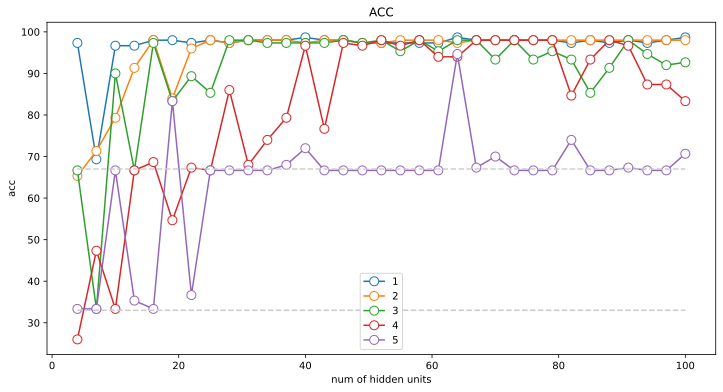

In [35]:
fix,ax = plt.subplots(1,figsize=(12,6))

ax.plot(numUnits,accs,'o-',markerfacecolor="w",markersize=9)
ax.plot(numUnits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numUnits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numLayers)
ax.set_title("ACC")
ax.set_xlabel("num of hidden units")
ax.set_ylabel("acc")
plt.show()

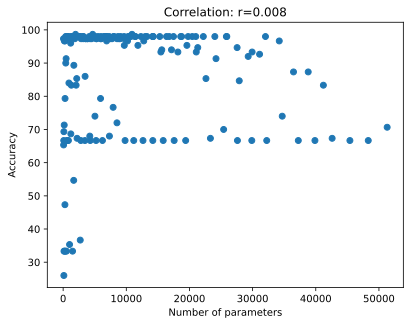

In [36]:
x = totalParams.flatten()
y = accs.flatten()

r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel("Number of parameters")
plt.ylabel("Accuracy")
plt.title("Correlation: r=" + str(np.round(r,3)))
plt.show()